In [1]:
# # 1. Carga y Configuración

# ## Importación de Librerías
# Importamos todas las herramientas necesarias para nuestro análisis.
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os

# Configuraciones iniciales
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Configuración del dispositivo (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ## Carga de Datos
# Cargamos el dataset de entrenamiento.

# Asegúrate de que la ruta al archivo sea correcta
file_path = '../../Datos/df_train.parquet'

if not os.path.exists(file_path):
    print(f"Error: El archivo no se encuentra en la ruta especificada: {file_path}")
    print("Por favor, ajusta la variable 'file_path' a la ubicación correcta de tu archivo 'df_train.parquet'.")
    # Para que el resto del notebook pueda ejecutarse con datos de ejemplo, creamos un dataframe dummy.
    # EN UN CASO REAL, DETENDRÍAS LA EJECUCIÓN AQUÍ.
    print("Creando un DataFrame de ejemplo para demostración...")
    data = {
        'anio': np.repeat(np.arange(2015, 2022), 52 * 10),
        'semana': np.tile(np.repeat(np.arange(1, 53), 10), 7),
        'id_bar': np.tile(np.arange(1, 11), 52 * 7),
        'dengue': np.random.randint(0, 20, 52 * 7 * 10),
        'ESTRATO': np.random.randint(1, 6, 52 * 7 * 10),
        'temperatura_mean': np.random.uniform(20, 30, 52 * 7 * 10),
        'lluvia_mean': np.random.uniform(0, 50, 52 * 7 * 10)
    }
    df = pd.DataFrame(data)
    df = df.sort_values(by=['anio', 'semana', 'id_bar']).reset_index(drop=True)
else:
    df = pd.read_parquet(file_path)

print("Forma inicial de los datos:", df.shape)
print("Primeras filas de los datos:")
print(df.head())

Usando dispositivo: cuda
Forma inicial de los datos: (3680, 20)
Primeras filas de los datos:
          id  id_bar  anio  semana  ESTRATO  area_barrio  dengue  \
0  4_2015_01       4  2015       1      3.0        0.560     0.0   
1  5_2015_01       5  2015       1      3.0        0.842     0.0   
2  3_2015_01       3  2015       1      1.0        0.781     0.0   
3  8_2015_01       8  2015       1      2.0        0.394     0.0   
4  9_2015_01       9  2015       1      2.0        0.292     0.0   

   concentraciones  vivienda  equipesado  sumideros  maquina  lluvia_mean  \
0              0.0       0.0         0.0        0.0      0.0     0.000651   
1              0.0       0.0         0.0        0.0      0.0     0.000651   
2              0.0       0.0         0.0        0.0      0.0     0.000651   
3              0.0       0.0         0.0        0.0      0.0     0.000651   
4              0.0       0.0         0.0        0.0      0.0     0.000651   

   lluvia_var  lluvia_max  lluvia_m

In [2]:
# Eliminamos los registros donde la columna 'semana' es igual a 53
df = df[df['semana'] != 53].reset_index(drop=True)
print(f"Datos después de eliminar semana 53: {df.shape}")

Datos después de eliminar semana 53: (3640, 20)


In [3]:
# # 2. Análisis Exploratorio y Preprocesamiento

# ## Creación de la Fecha y Establecimiento del Índice
def get_iso_date(row):
    """Convierte año y semana ISO a un objeto de fecha (lunes de esa semana)."""
    return datetime.fromisocalendar(int(row['anio']), int(row['semana']), 1)

df['fecha'] = df.apply(get_iso_date, axis=1)
df = df.sort_values(by=['fecha', 'id_bar']).set_index('fecha')
print("\nDatos con índice de fecha:")
print(df.head())

# ## Codificación de Variables Categóricas y Escalado
target_col = 'dengue'
categorical_features = ['id_bar', 'ESTRATO']
numeric_features = [col for col in df.columns if df[col].dtype != 'object' and col not in categorical_features + [target_col, 'anio', 'semana']]

print(f"\nVariable Objetivo: {target_col}")
print(f"Variables Categóricas: {categorical_features}")
print(f"Variables Numéricas (Covariables): {numeric_features}")

# Aplicamos One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
encoded_cols = [col for col in df_encoded.columns if any(cat_col in col for cat_col in categorical_features)]
final_numeric_features = numeric_features + encoded_cols

# Escalado de datos
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
df_scaled = df_encoded.copy()
df_scaled[final_numeric_features] = feature_scaler.fit_transform(df_encoded[final_numeric_features])
df_scaled[target_col] = target_scaler.fit_transform(df_encoded[[target_col]])

print("\nDatos preprocesados y escalados:")
print(df_scaled.head())

# ## División de Datos en Entrenamiento y Validación
train_df = df_scaled[df_scaled['anio'] < 2021]
val_df = df_scaled[df_scaled['anio'] >= 2021]

train_df = train_df.drop(columns=['id', 'anio', 'semana'])
val_df = val_df.drop(columns=['id', 'anio', 'semana'])

model_features = [target_col] + final_numeric_features
X_train_df = train_df[model_features]
y_train_df = train_df[[target_col]]
X_val_df = val_df[model_features]
y_val_df = val_df[[target_col]]

print(f"\nForma del conjunto de entrenamiento: {X_train_df.shape}")
print(f"Forma del conjunto de validación: {X_val_df.shape}")


Datos con índice de fecha:
                   id  id_bar  anio  semana  ESTRATO  area_barrio  dengue  \
fecha                                                                       
2014-12-29  0_2015_01       0  2015       1      2.0        1.196     0.0   
2014-12-29  1_2015_01       1  2015       1      1.0        0.600     0.0   
2014-12-29  2_2015_01       2  2015       1      2.0        0.780     0.0   
2014-12-29  3_2015_01       3  2015       1      1.0        0.781     0.0   
2014-12-29  4_2015_01       4  2015       1      3.0        0.560     0.0   

            concentraciones  vivienda  equipesado  sumideros  maquina  \
fecha                                                                   
2014-12-29              0.0       0.0         0.0        0.0      0.0   
2014-12-29              0.0       0.0         0.0        0.0      0.0   
2014-12-29              0.0       0.0         0.0        0.0      0.0   
2014-12-29              0.0       0.0         0.0        0.0      0

In [4]:
# # 3. Creación de Secuencias

# Los modelos LSTM requieren que los datos de entrada tengan una forma específica: [muestras, pasos_de_tiempo, características].
def create_sequences(input_data, target_data, window_size):
    """Crea secuencias y etiquetas para el modelo LSTM."""
    X, y = [], []
    # Aseguramos que la data sea suficiente para al menos una secuencia
    if len(input_data) <= window_size:
        return np.array(X), np.array(y)
        
    for i in range(len(input_data) - window_size):
        X.append(input_data[i:(i + window_size)])
        y.append(target_data[i + window_size])
    return np.array(X), np.array(y)

# La creación de secuencias y tensores se moverá a la función 'objective' de Optuna
# para permitir que 'window_size' sea un hiperparámetro.
print("La función 'create_sequences' ha sido definida.")
print("La creación de secuencias se realizará dinámicamente durante la optimización.")

La función 'create_sequences' ha sido definida.
La creación de secuencias se realizará dinámicamente durante la optimización.


In [5]:
# # 4. Optimización de Hiperparámetros con Optuna

# ## Clase para Early Stopping (CORREGIDA)
class EarlyStopping:
    """Detiene el entrenamiento si la pérdida de validación no mejora después de un número dado de épocas."""
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf # CORRECCIÓN: Cambiado de np.Inf a np.inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose and self.counter % 5 == 0:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0

# ## Definición del Modelo LSTM en PyTorch (con Batch Normalization)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        out = self.batch_norm(last_time_step_out)
        out = self.dropout(out)
        out = self.linear(out)
        return out

# ## Función `objective` para Optuna (Mejorada)
def objective(trial):
    # Hiperparámetros a optimizar
    window_size = trial.suggest_int('window_size', 12, 52, step=4)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_size = trial.suggest_int('units', 32, 256, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Crear secuencias con el window_size actual del trial
    X_train, y_train = create_sequences(X_train_df.values, y_train_df.values, window_size)
    X_val, y_val = create_sequences(X_val_df.values, y_val_df.values, window_size)
    
    if len(X_train) == 0 or len(X_val) == 0:
        return float('inf')

    # Convertir a tensores de PyTorch
    X_train_tensor = torch.from_numpy(X_train).float().to(device)
    y_train_tensor = torch.from_numpy(y_train).float().to(device)
    X_val_tensor = torch.from_numpy(X_val).float().to(device)
    y_val_tensor = torch.from_numpy(y_val).float().to(device)

    # Configuración del modelo y entrenamiento
    input_size = X_train.shape[2]
    output_size = 1
    model = LSTMModel(input_size, hidden_size, n_layers, output_size, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    early_stopping = EarlyStopping(patience=50, verbose=False)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    epochs = 100 

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor)
        
        scheduler.step(val_loss.item())
        early_stopping(val_loss.item(), model)
        if early_stopping.early_stop:
            break
            
    return early_stopping.val_loss_min

# ## Ejecución del Estudio de Optuna
print("\nIniciando optimización de hiperparámetros con Optuna...")
N_TRIALS = 400 # Puede tomar tiempo, ajustar si es necesario
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

print("\nOptimización finalizada.")
print(f"Mejor trial (MSE): {study.best_value}")
print("Mejores hiperparámetros:")
best_params = study.best_params
print(best_params)

[I 2025-06-23 17:43:56,465] A new study created in memory with name: no-name-3583c11f-5620-4a1b-b2bc-c4a301f16fad



Iniciando optimización de hiperparámetros con Optuna...


[I 2025-06-23 17:44:16,303] Trial 0 finished with value: 0.0027102057356387377 and parameters: {'window_size': 52, 'n_layers': 3, 'units': 54, 'dropout': 0.1490141059853669, 'learning_rate': 0.004487971019188066, 'batch_size': 32}. Best is trial 0 with value: 0.0027102057356387377.
[I 2025-06-23 17:44:23,624] Trial 1 finished with value: 0.0032494585029780865 and parameters: {'window_size': 12, 'n_layers': 2, 'units': 121, 'dropout': 0.3257992389467468, 'learning_rate': 0.004383377724507462, 'batch_size': 64}. Best is trial 0 with value: 0.0027102057356387377.
[I 2025-06-23 17:44:39,676] Trial 2 finished with value: 0.0028194431215524673 and parameters: {'window_size': 44, 'n_layers': 2, 'units': 240, 'dropout': 0.40343807408350274, 'learning_rate': 0.0010356995170769804, 'batch_size': 64}. Best is trial 0 with value: 0.0027102057356387377.
[I 2025-06-23 17:44:45,027] Trial 3 finished with value: 0.0032622958533465862 and parameters: {'window_size': 16, 'n_layers': 2, 'units': 52, 'dro


Optimización finalizada.
Mejor trial (MSE): 0.0025727611500769854
Mejores hiperparámetros:
{'window_size': 52, 'n_layers': 2, 'units': 243, 'dropout': 0.3827990964811363, 'learning_rate': 0.00749056638159655, 'batch_size': 32}



Re-entrenando el modelo final con los datos combinados (2015-2021)...
Forma de las secuencias completas (X) con window_size=52: (3588, 52, 26)
Forma de las etiquetas completas (y): (3588, 1)
Epoch [10/300], Loss: 0.011464
Epoch [20/300], Loss: 0.009058
Epoch [30/300], Loss: 0.009023
Epoch [40/300], Loss: 0.008637
Epoch [50/300], Loss: 0.007877
Epoch [60/300], Loss: 0.007589
Epoch [70/300], Loss: 0.006748
Epoch [80/300], Loss: 0.014731
Epoch [90/300], Loss: 0.012797
Epoch [100/300], Loss: 0.012625
Epoch [110/300], Loss: 0.012078
Epoch [120/300], Loss: 0.011496
Epoch [130/300], Loss: 0.011289
Epoch [140/300], Loss: 0.011157
Epoch [150/300], Loss: 0.010803
Epoch [160/300], Loss: 0.008358
Epoch [170/300], Loss: 0.007569
Epoch [180/300], Loss: 0.007797
Epoch [190/300], Loss: 0.007581
Epoch [200/300], Loss: 0.007597
Epoch [210/300], Loss: 0.006968
Epoch [220/300], Loss: 0.007108
Epoch [230/300], Loss: 0.007034
Epoch [240/300], Loss: 0.006179
Epoch [250/300], Loss: 0.006314
Epoch [260/300], 

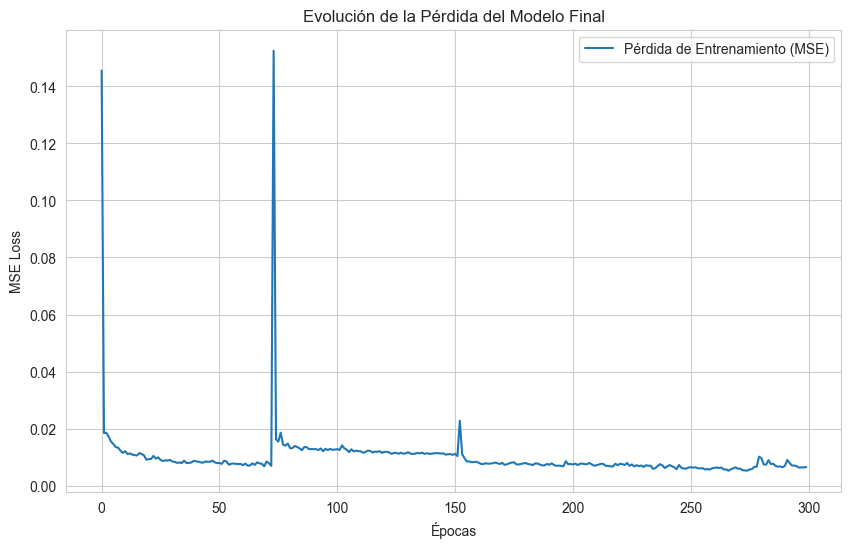

In [6]:
# # 5. Entrenamiento del Modelo Final

# ## Preparación de datos combinados
print("\nRe-entrenando el modelo final con los datos combinados (2015-2021)...")

# MEJORA: Recuperamos el mejor window_size de Optuna
WINDOW_SIZE = best_params['window_size'] 

full_df = pd.concat([X_train_df, X_val_df])
full_target_df = pd.concat([y_train_df, y_val_df])
X_full, y_full = create_sequences(full_df.values, full_target_df.values, WINDOW_SIZE)
X_full_tensor = torch.from_numpy(X_full).float().to(device)
y_full_tensor = torch.from_numpy(y_full).float().to(device)

print(f"Forma de las secuencias completas (X) con window_size={WINDOW_SIZE}: {X_full.shape}")
print(f"Forma de las etiquetas completas (y): {y_full.shape}")

# ## Instanciación y Entrenamiento
input_size = X_full.shape[2]
output_size = 1

final_model = LSTMModel(
    input_size=input_size,
    hidden_size=best_params['units'],
    num_layers=best_params['n_layers'],
    output_size=output_size,
    dropout=best_params['dropout']
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
batch_size = best_params['batch_size']

full_dataset = TensorDataset(X_full_tensor, y_full_tensor)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

epochs = 300 # Más épocas para el modelo final
history = {'loss': []}

for epoch in range(epochs):
    final_model.train()
    epoch_loss = 0
    for X_batch, y_batch in full_loader:
        optimizer.zero_grad()
        y_pred = final_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(full_loader)
    history['loss'].append(avg_epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.6f}")
        
print("\nEntrenamiento final completado.")

# ## Gráfica del Historial de Entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.title('Evolución de la Pérdida del Modelo Final')
plt.xlabel('Épocas')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [7]:
# # 6. Generación de Pronósticos para 2022

print("\nGenerando pronósticos para 2022 de forma autorregresiva...")

weeks_to_forecast = 52
unique_barrios = df['id_bar'].unique()
all_forecasts = []

# Suposición crítica: Usar covariables de 2021 para 2022.
covariates_2021 = df_scaled[df_scaled['anio'] == 2021].copy()
covariates_2021['semana'] = covariates_2021.index.isocalendar().week

# ---------------------------------------------------------------------------
# CORRECCIÓN: Se filtra el df original por el año 2021 para asegurar 
# que las longitudes coincidan antes de asignar la columna 'id_bar'.
covariates_2021['id_bar'] = df[df['anio'] == 2021]['id_bar'].values
# ---------------------------------------------------------------------------


final_model.eval()
with torch.no_grad():
    for id_b in sorted(unique_barrios): # Ordenar para consistencia
        print(f"  Pronosticando para el barrio: {id_b}")
        
        # Construir el nombre de la columna one-hot para el barrio actual
        id_bar_col_name = f'id_bar_{float(id_b)}'
        
        # Filtrar los datos del último año para el barrio específico
        if id_bar_col_name in val_df.columns:
            last_year_data = val_df[val_df[id_bar_col_name] == 1]
        else:
            # Caso para el primer barrio eliminado por drop_first=True
            id_bar_cols = [col for col in val_df.columns if 'id_bar_' in col]
            last_year_data = val_df[val_df[id_bar_cols].sum(axis=1) == 0]

        if len(last_year_data) < WINDOW_SIZE:
             print(f"    Advertencia: Datos insuficientes para {id_b} en 2021 ({len(last_year_data)}<{WINDOW_SIZE}). Saltando...")
             continue
        
        current_sequence = last_year_data[model_features].values[-WINDOW_SIZE:]

        for week_num in range(1, weeks_to_forecast + 1):
            input_tensor = torch.from_numpy(current_sequence).float().unsqueeze(0).to(device)
            scaled_prediction = final_model(input_tensor).item()
            
            unscaled_prediction = target_scaler.inverse_transform(np.array([[scaled_prediction]]))
            unscaled_prediction = max(0, unscaled_prediction[0][0])
            
            all_forecasts.append({
                'id_bar': id_b, 'anio': 2022, 'semana': week_num, 'dengue': unscaled_prediction
            })

            future_covariates = covariates_2021[
                (covariates_2021['id_bar'] == id_b) & (covariates_2021['semana'] == week_num)
            ]
            
            if future_covariates.empty:
                new_row_features = current_sequence[-1, 1:] 
            else:
                new_row_features = future_covariates[final_numeric_features].values[0]
            
            new_row = np.insert(new_row_features, 0, scaled_prediction)
            current_sequence = np.vstack([current_sequence[1:], new_row])

print("\nGeneración de pronósticos completada.")


Generando pronósticos para 2022 de forma autorregresiva...
  Pronosticando para el barrio: 0
  Pronosticando para el barrio: 1
  Pronosticando para el barrio: 2
  Pronosticando para el barrio: 3
  Pronosticando para el barrio: 4
  Pronosticando para el barrio: 5
  Pronosticando para el barrio: 6
  Pronosticando para el barrio: 7
  Pronosticando para el barrio: 8
  Pronosticando para el barrio: 9

Generación de pronósticos completada.


In [10]:
# # 7. Creación del Archivo de Submission

# Convertimos la lista de pronósticos en un DataFrame y le damos el formato solicitado.
forecast_df = pd.DataFrame(all_forecasts)

# Crear la columna 'id' con el formato [id_bar]_[anio]_[semana]
forecast_df['id'] = forecast_df.apply(
    lambda row: f"{int(row['id_bar'])}_{int(row['anio'])}_{int(row['semana']):02d}",
    axis=1
)

# Seleccionar y redondear la columna de dengue
submission_df = forecast_df[['id', 'dengue']]
submission_df['dengue'] = submission_df['dengue'].round().astype(int)

# Guardar el archivo final
fecha_actual = datetime.now().strftime('%Y%m%d')
output_filename = f'pronosticos_dengue_2022_{fecha_actual}.csv'
submission_df.to_csv(output_filename, index=False)

print(f"\nArchivo de pronósticos guardado como '{output_filename}'")
print("Primeras filas del archivo de salida:")
print(submission_df.head())
print("\nÚltimas filas del archivo de salida:")
print(submission_df.tail())


Archivo de pronósticos guardado como 'pronosticos_dengue_2022_20250623.csv'
Primeras filas del archivo de salida:
          id  dengue
0  0_2022_01       2
1  0_2022_02       2
2  0_2022_03       2
3  0_2022_04       2
4  0_2022_05       2

Últimas filas del archivo de salida:
            id  dengue
515  9_2022_48       7
516  9_2022_49       6
517  9_2022_50       7
518  9_2022_51       7
519  9_2022_52       6
